In [1]:
import torch
import sys
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import torchvision

In [2]:
!pip install gdown

In [3]:
def get_file_id_by_model(folder_name):
  file_id = {'resnet18_100-epochs_stl10': '14_nH2FkyKbt61cieQDiSbBVNP8-gtwgF',
             'resnet18_100-epochs_cifar10': '1lc2aoVtrAetGn0PnTkOyFzPCIucOJq7C',
             'resnet50_50-epochs_stl10': '1ByTKAUsdm_X7tLcii6oAEl5qFRqRMZSu'}
  return file_id.get(folder_name, "Model not found.")

In [4]:
folder_name = 'resnet18_100-epochs_cifar10'
file_id = get_file_id_by_model(folder_name)
print(folder_name, file_id)

resnet18_100-epochs_cifar10 1lc2aoVtrAetGn0PnTkOyFzPCIucOJq7C


In [5]:
# download and extract model files
os.system('gdown https://drive.google.com/uc?id={}'.format(file_id))
os.system('unzip {}'.format(folder_name))
!ls

checkpoint_0100.pth.tar
config.yml
data
events.out.tfevents.1610901418.4cb2c837708d.2683796.0
resnet18_100-epochs_cifar10.zip
run.log
sample_data


In [6]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [8]:
def get_stl10_data_loaders(download, batch_size=256):
  train_dataset = datasets.STL10('./data', split='train', download=download,
                                  transform=transforms.ToTensor())

  train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            num_workers=10, drop_last=False, shuffle=True)
  
  test_dataset = datasets.STL10('./data', split='test', download=download,
                                  transform=transforms.ToTensor())

  test_loader = DataLoader(test_dataset, batch_size=2*batch_size,
                            num_workers=10, drop_last=False, shuffle=False)
  return train_loader, test_loader

def get_cifar10_data_loaders(download, shuffle=False, batch_size=256):
  train_dataset = datasets.CIFAR10('./data', train=True, download=download,
                                  transform=transforms.ToTensor())

  train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            num_workers=10, drop_last=False, shuffle=True)
  
  test_dataset = datasets.CIFAR10('./data', train=False, download=download,
                                  transform=transforms.ToTensor())

  test_loader = DataLoader(test_dataset, batch_size=2*batch_size,
                            num_workers=10, drop_last=False, shuffle=False)
  return train_loader, test_loader

In [9]:
with open(os.path.join('./config.yml')) as file:
  config = yaml.load(file)

In [10]:
if config.arch == 'resnet18':
  model = torchvision.models.resnet18(pretrained=False, num_classes=10).to(device)
elif config.arch == 'resnet50':
  model = torchvision.models.resnet50(pretrained=False, num_classes=10).to(device)

In [11]:
checkpoint = torch.load('checkpoint_0100.pth.tar', map_location=device)
state_dict = checkpoint['state_dict']

for k in list(state_dict.keys()):

  if k.startswith('backbone.'):
    if k.startswith('backbone') and not k.startswith('backbone.fc'):
      # remove prefix
      state_dict[k[len("backbone."):]] = state_dict[k]
  del state_dict[k]

In [12]:
log = model.load_state_dict(state_dict, strict=False)
assert log.missing_keys == ['fc.weight', 'fc.bias']

In [13]:
if config.dataset_name == 'cifar10':
  train_loader, test_loader = get_cifar10_data_loaders(download=True)
elif config.dataset_name == 'stl10':
  train_loader, test_loader = get_stl10_data_loaders(download=True)
print("Dataset:", config.dataset_name)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified
Dataset: stl10


In [14]:
# freeze all layers but the last fc
for name, param in model.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False

parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
assert len(parameters) == 2  # fc.weight, fc.bias

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0008)
criterion = torch.nn.CrossEntropyLoss().to(device)

In [16]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [17]:
epochs = 20
top_1_train_accuracy_list = []
top_1_test_accuracy_list = []
losses = []
for epoch in range(epochs):
  top1_train_accuracy = 0
  for counter, (x_batch, y_batch) in enumerate(train_loader):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(x_batch)
    loss = criterion(logits, y_batch)
    top1 = accuracy(logits, y_batch, topk=(1,))
    top1_train_accuracy += top1[0]

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  losses.append(loss.item())
  top1_train_accuracy /= (counter + 1)
  top1_accuracy = 0
  top5_accuracy = 0
  for counter, (x_batch, y_batch) in enumerate(test_loader):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(x_batch)
  
    top1, top5 = accuracy(logits, y_batch, topk=(1,5))
    top1_accuracy += top1[0]
    top5_accuracy += top5[0]
  
  top1_accuracy /= (counter + 1)
  top5_accuracy /= (counter + 1)
  print(f"Epoch {epoch}\tTop1 Train accuracy {top1_train_accuracy.item()}\tTop1 Test accuracy: {top1_accuracy.item()}\tTop5 test acc: {top5_accuracy.item()}")
  top_1_train_accuracy_list.append(top1_train_accuracy.item())
  top_1_test_accuracy_list.append(top1_accuracy.item())
  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0	Top1 Train accuracy 22.518383026123047	Top1 Test accuracy: 30.23193359375	Top5 test acc: 87.529296875
Epoch 1	Top1 Train accuracy 35.98805236816406	Top1 Test accuracy: 38.2373046875	Top5 test acc: 92.02392578125
Epoch 2	Top1 Train accuracy 39.71277618408203	Top1 Test accuracy: 42.65869140625	Top5 test acc: 92.900390625
Epoch 3	Top1 Train accuracy 45.02412796020508	Top1 Test accuracy: 44.716796875	Top5 test acc: 93.45947265625
Epoch 4	Top1 Train accuracy 46.640625	Top1 Test accuracy: 46.14501953125	Top5 test acc: 93.67431640625
Epoch 5	Top1 Train accuracy 47.07146072387695	Top1 Test accuracy: 47.36328125	Top5 test acc: 94.08447265625
Epoch 6	Top1 Train accuracy 49.02918243408203	Top1 Test accuracy: 47.88818359375	Top5 test acc: 94.12353515625
Epoch 7	Top1 Train accuracy 49.92417526245117	Top1 Test accuracy: 48.8623046875	Top5 test acc: 94.40673828125
Epoch 8	Top1 Train accuracy 50.37224197387695	Top1 Test accuracy: 49.580078125	Top5 test acc: 94.365234375
Epoch 9	Top1 Train accu

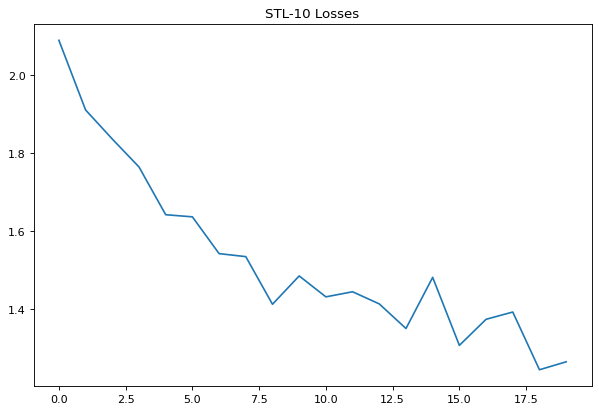

In [18]:
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(losses)
plt.title('STL-10 Losses')
plt.show()

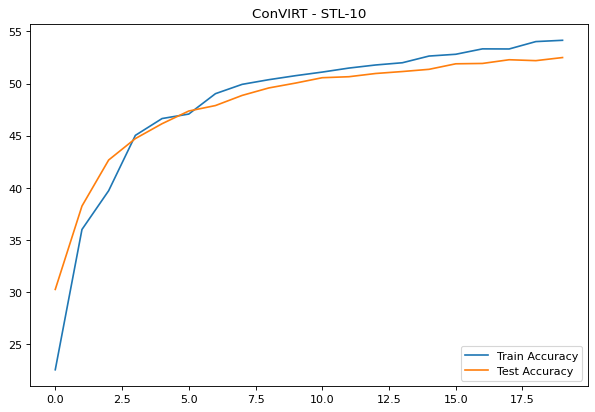

In [19]:
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(top_1_train_accuracy_list, label="Train Accuracy")
plt.plot(top_1_test_accuracy_list, label = "Test Accuracy")
plt.legend(loc="lower right")
plt.title("ConVIRT - STL-10")
plt.show()